In [1]:
import random

from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf

from config import (
    ALL_CLASSES,
    BATCH_SIZE,
    CLASS2LABEL,
    DATA_FILE,
    LABEL,
    MODELS_TO_PLOT,
    MODEL_FILE,
    PARAM_FILE,
    PARAM_RANGE_PERCEPTRON,
    RECALL_RELEVANT_CLASSES
)
from deep_net import train_neural_net
from lgb_model import train_lgb_model
from load_data import load_data
from snippets import (
    calculate_weights,
    count_class_occurences,
    get_random_parameters,
    import_perceptron_stats,
    plot_confusion_matrix,
    plot_feature_importance,
    plot_training_progress,
    plot_class_shares
)


Using TensorFlow backend.


In [2]:
SAMPLE_SIZE = int(1e5)
PROCESS_SIGNALS = False
train_set, test_set = load_data(DATA_FILE, SAMPLE_SIZE, PROCESS_SIGNALS)

features = list(train_set)
features.remove(LABEL)
y_true = test_set[LABEL]

/home/magdalena/Desktop/reduce-aviation-fatalities/venv/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/magdalena/Desktop/reduce-aviation-fatalities/venv/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/magdalena/Desktop/reduce-aviation-fatalities/venv/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/home/magdalena/Desktop/reduce-aviation-fatalities/venv/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype float32 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X,

In [3]:
train_set.head()

,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,eeg_t5,eeg_t3,eeg_fp2,eeg_o1,eeg_p3,...,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr,event
607918,0.641631,0.397364,0.420771,0.471625,0.372916,0.150855,0.342309,0.351059,0.239132,0.247256,...,0.401136,0.266728,0.264150,0.362712,0.419112,0.295140,0.209937,0.792772,0.839058,2
2531915,0.331721,0.424134,0.322640,0.425470,0.425161,0.601340,0.457908,0.293838,0.549865,0.489193,...,0.483410,0.461122,0.498675,0.450225,0.408332,0.484432,0.302412,0.420672,0.634366,0
735498,0.345557,0.360673,0.350058,0.492159,0.629931,0.424464,0.475733,0.311506,0.406740,0.409019,...,0.409624,0.351595,0.452885,0.413784,0.480802,0.298035,0.511677,0.466282,0.000000,0
1493258,0.316793,0.412279,0.553607,0.517419,0.592339,0.343989,0.287481,0.353491,0.476781,0.336072,...,0.450455,0.431516,0.398016,0.312910,0.436761,0.536719,0.205329,0.787919,0.117151,0
1826881,0.373166,0.360276,0.521897,0.586096,0.623634,0.643829,0.552583,0.369188,0.579490,0.595216,...,0.585881,0.618404,0.581613,0.568412,0.560418,0.582091,0.591963,0.909513,0.728433,0


In [4]:
train_set.dtypes

eeg_fp1     float32
eeg_f7      float32
eeg_f8      float32
eeg_t4      float32
eeg_t6      float32
eeg_t5      float32
eeg_t3      float32
eeg_fp2     float32
eeg_o1      float32
eeg_p3      float32
eeg_pz      float32
eeg_f3      float32
eeg_fz      float32
eeg_f4      float32
eeg_c4      float32
eeg_p4      float32
eeg_poz     float32
eeg_c3      float32
eeg_cz      float32
eeg_o2      float32
ecg         float32
r           float32
gsr         float32
event      category
dtype: object

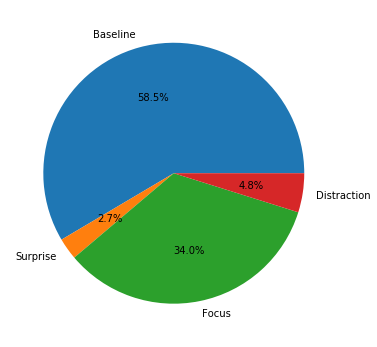

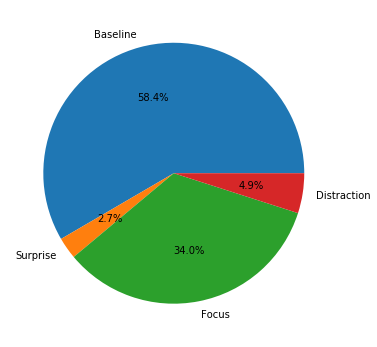

In [5]:
# Class distribution
for dataset in [train_set, test_set]:
    class2counts = count_class_occurences(dataset[LABEL], ALL_CLASSES)   
    counts = [class2counts[key] for key in class2counts.keys()]
    labels = [CLASS2LABEL[key] for key in class2counts.keys()]

    plot_class_shares(counts, labels)

In [6]:
# Calculate weights

class2count = count_class_occurences(train_set[LABEL], ALL_CLASSES)
class_weights = calculate_weights(class2count, ALL_CLASSES)
metric_weights = calculate_weights(class2count, RECALL_RELEVANT_CLASSES)

Text(0, 0.5, 'weight')

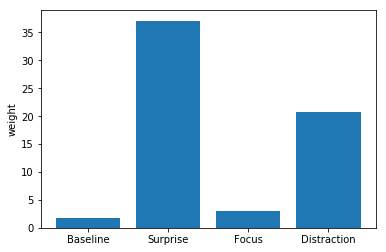

In [7]:
# Show class weights
# Used for training

class_indices = list(CLASS2LABEL.keys())
plt.bar(class_indices, [class_weights[i] for i in class_indices])
plt.xticks(class_indices, [CLASS2LABEL[i] for i in class_indices])
plt.ylabel("weight")

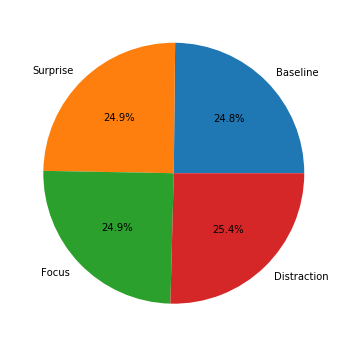

In [8]:
# Classes after rebalancing
balanced_weights = [counts[i]*class_weights[i] for i in range(len(ALL_CLASSES))]

plot_class_shares(balanced_weights, labels)

Text(0, 0.5, 'weight')

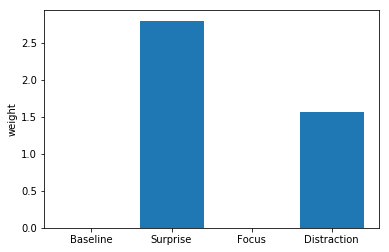

In [9]:
# Weights for evaluation metric (recall)
# Used for model choice

plt.bar(class_indices, [metric_weights[i] for i in class_indices])
plt.xticks(class_indices, [CLASS2LABEL[i] for i in class_indices])
plt.ylabel("weight")

In [10]:
# Hyperparameter swipe

learning_rate = []
lr_decay = []
deep_layers = []

for i in range(100):
    learning_rate.append(
        get_random_parameters(param_range=PARAM_RANGE_PERCEPTRON["learning_rate"], log_scale=True, is_integer=False))

    lr_decay.append(
        random.getrandbits(1)*get_random_parameters(param_range=PARAM_RANGE_PERCEPTRON["lr_decay"], log_scale=True, is_integer=False))

    deep_layers.append(get_random_parameters(param_range=PARAM_RANGE_PERCEPTRON["layers"], log_scale=False, is_integer=True))

/home/magdalena/Desktop/reduce-aviation-fatalities/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'Hyperparameters on log scale')

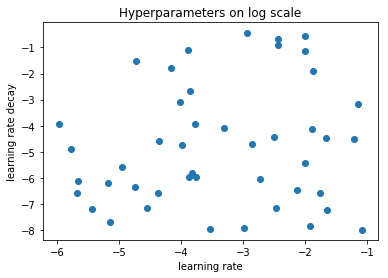

In [11]:
plt.scatter(np.log10(learning_rate), np.log10(lr_decay))
plt.xlabel("learning rate")
plt.ylabel("learning rate decay")
plt.title("Hyperparameters on log scale")

Text(0.5, 1.0, 'Hyperparameters on regular scale')

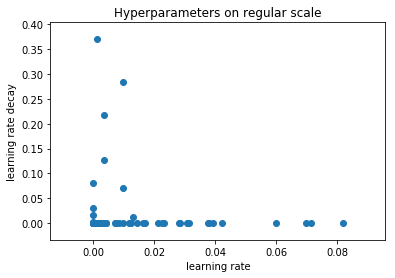

In [12]:
plt.scatter(learning_rate, lr_decay)
plt.xlabel("learning rate")
plt.ylabel("learning rate decay")
plt.title("Hyperparameters on regular scale")

Text(0.5, 1.0, 'Hyperparameters on log scale')

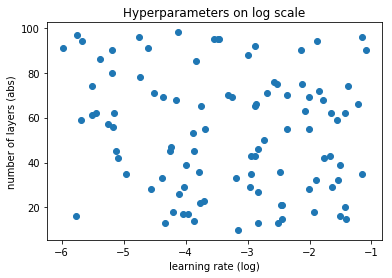

In [13]:
plt.scatter(np.log10(learning_rate), deep_layers)
plt.xlabel("learning rate (log)")
plt.ylabel("number of neurons (abs)")
plt.title("Hyperparameters on log scale")

Text(0.5, 1.0, 'Hyperparameters on regular scale')

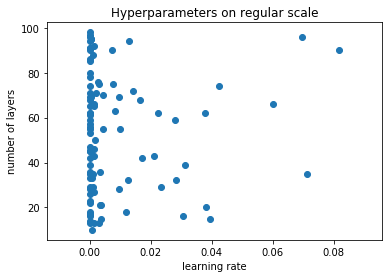

In [14]:
plt.scatter(learning_rate, deep_layers)
plt.xlabel("learning rate")
plt.ylabel("number of neurons")
plt.title("Hyperparameters on regular scale")

In [15]:
# Train NN
deep_networks, recall_deep_net, _ = train_neural_net(train_set, test_set, LABEL, 1/60, store_intermediate_results=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 80000 samples
Epoch 1/1000
80000/80000 [==============================] - 0s 1us/sample - loss: 5.6854 - weighted_acc: 0.2501
Epoch 2/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6853 - weighted_acc: 0.2501
Epoch 3/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6853 - weighted_acc: 0.2501
Epoch 4/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6852 - weighted_acc: 0.2501
Epoch 5/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6851 - weighted_acc: 0.2501
Epoch 6/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6851 - weighted_acc: 0.2501
Epoch 7/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6850 - weighted_acc: 0.2501
Epoch 8/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6849 - weighted_acc: 0.2501


Epoch 70/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6804 - weighted_acc: 0.2501
Epoch 71/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6803 - weighted_acc: 0.2501
Epoch 72/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6803 - weighted_acc: 0.2501
Epoch 73/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6802 - weighted_acc: 0.2501
Epoch 74/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6801 - weighted_acc: 0.2501
Epoch 75/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6800 - weighted_acc: 0.2501
Epoch 76/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6800 - weighted_acc: 0.2501
Epoch 77/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6799 - weighted_acc: 0.2501
Epoch 78/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6798 - weig

Epoch 143/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6752 - weighted_acc: 0.2501
Epoch 144/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6752 - weighted_acc: 0.2501
Epoch 145/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6751 - weighted_acc: 0.2501
Epoch 146/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6750 - weighted_acc: 0.2501
Epoch 147/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6750 - weighted_acc: 0.2501
Epoch 148/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6749 - weighted_acc: 0.2501
Epoch 149/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6748 - weighted_acc: 0.2501
Epoch 150/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6747 - weighted_acc: 0.2501
Epoch 151/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.67

Epoch 215/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6703 - weighted_acc: 0.2501
Epoch 216/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6702 - weighted_acc: 0.2501
Epoch 217/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6701 - weighted_acc: 0.2501
Epoch 218/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6701 - weighted_acc: 0.2501
Epoch 219/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6700 - weighted_acc: 0.2501
Epoch 220/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6699 - weighted_acc: 0.2501
Epoch 221/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6699 - weighted_acc: 0.2501
Epoch 222/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6698 - weighted_acc: 0.2501
Epoch 223/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.66

Epoch 287/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6654 - weighted_acc: 0.2502
Epoch 288/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6654 - weighted_acc: 0.2502
Epoch 289/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6653 - weighted_acc: 0.2502
Epoch 290/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6652 - weighted_acc: 0.2502
Epoch 291/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6652 - weighted_acc: 0.2502
Epoch 292/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6651 - weighted_acc: 0.2502
Epoch 293/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6650 - weighted_acc: 0.2502
Epoch 294/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6650 - weighted_acc: 0.2502
Epoch 295/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.66

Epoch 359/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6607 - weighted_acc: 0.2502
Epoch 360/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6607 - weighted_acc: 0.2502
Epoch 361/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6606 - weighted_acc: 0.2502
Epoch 362/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6606 - weighted_acc: 0.2502
Epoch 363/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6605 - weighted_acc: 0.2502
Epoch 364/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6604 - weighted_acc: 0.2502
Epoch 365/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6604 - weighted_acc: 0.2502
Epoch 366/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6603 - weighted_acc: 0.2502
Epoch 367/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.66

Epoch 431/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6562 - weighted_acc: 0.2503
Epoch 432/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6561 - weighted_acc: 0.2503
Epoch 433/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6561 - weighted_acc: 0.2503
Epoch 434/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6560 - weighted_acc: 0.2503
Epoch 435/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6560 - weighted_acc: 0.2503
Epoch 436/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6559 - weighted_acc: 0.2503
Epoch 437/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6558 - weighted_acc: 0.2503
Epoch 438/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6558 - weighted_acc: 0.2503
Epoch 439/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.65

Epoch 503/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6518 - weighted_acc: 0.2505
Epoch 504/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6517 - weighted_acc: 0.2505
Epoch 505/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6517 - weighted_acc: 0.2505
Epoch 506/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6516 - weighted_acc: 0.2505
Epoch 507/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6516 - weighted_acc: 0.2505
Epoch 508/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6515 - weighted_acc: 0.2505
Epoch 509/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6514 - weighted_acc: 0.2505
Epoch 510/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6514 - weighted_acc: 0.2505
Epoch 511/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.65

Epoch 575/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6476 - weighted_acc: 0.2506
Epoch 576/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6475 - weighted_acc: 0.2506
Epoch 577/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6474 - weighted_acc: 0.2506
Epoch 578/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6474 - weighted_acc: 0.2506
Epoch 579/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6473 - weighted_acc: 0.2506
Epoch 580/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6473 - weighted_acc: 0.2507
Epoch 581/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6472 - weighted_acc: 0.2507
Epoch 582/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6472 - weighted_acc: 0.2507
Epoch 583/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.64

Epoch 647/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6435 - weighted_acc: 0.2509
Epoch 648/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6434 - weighted_acc: 0.2509
Epoch 649/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6433 - weighted_acc: 0.2509
Epoch 650/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6433 - weighted_acc: 0.2509
Epoch 651/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6432 - weighted_acc: 0.2509
Epoch 652/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6432 - weighted_acc: 0.2509
Epoch 653/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6431 - weighted_acc: 0.2509
Epoch 654/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6431 - weighted_acc: 0.2509
Epoch 655/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.64

Epoch 719/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6395 - weighted_acc: 0.2509
Epoch 720/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6394 - weighted_acc: 0.2510
Epoch 721/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6394 - weighted_acc: 0.2510
Epoch 722/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6393 - weighted_acc: 0.2510
Epoch 723/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6393 - weighted_acc: 0.2510
Epoch 724/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6392 - weighted_acc: 0.2510
Epoch 725/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6391 - weighted_acc: 0.2510
Epoch 726/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6391 - weighted_acc: 0.2510
Epoch 727/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.63

Epoch 791/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6356 - weighted_acc: 0.2511
Epoch 792/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6355 - weighted_acc: 0.2511
Epoch 793/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6355 - weighted_acc: 0.2511
Epoch 794/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6354 - weighted_acc: 0.2511
Epoch 795/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6354 - weighted_acc: 0.2511
Epoch 796/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6353 - weighted_acc: 0.2512
Epoch 797/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6353 - weighted_acc: 0.2512
Epoch 798/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6352 - weighted_acc: 0.2512
Epoch 799/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.63

Epoch 863/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6318 - weighted_acc: 0.2514
Epoch 864/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6317 - weighted_acc: 0.2514
Epoch 865/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6317 - weighted_acc: 0.2514
Epoch 866/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6316 - weighted_acc: 0.2514
Epoch 867/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6316 - weighted_acc: 0.2514
Epoch 868/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6315 - weighted_acc: 0.2514
Epoch 869/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6315 - weighted_acc: 0.2514
Epoch 870/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6314 - weighted_acc: 0.2514
Epoch 871/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.63

Epoch 935/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6281 - weighted_acc: 0.2516
Epoch 936/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6280 - weighted_acc: 0.2516
Epoch 937/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6280 - weighted_acc: 0.2516
Epoch 938/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6279 - weighted_acc: 0.2516
Epoch 939/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6279 - weighted_acc: 0.2516
Epoch 940/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6278 - weighted_acc: 0.2516
Epoch 941/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6278 - weighted_acc: 0.2516
Epoch 942/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.6277 - weighted_acc: 0.2516
Epoch 943/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.62

Epoch 7/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.5921 - weighted_acc: 0.2502
Epoch 8/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.5881 - weighted_acc: 0.2502
Epoch 9/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.5843 - weighted_acc: 0.2501
Epoch 10/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.5808 - weighted_acc: 0.2503
Epoch 11/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.5775 - weighted_acc: 0.2504
Epoch 12/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.5745 - weighted_acc: 0.2504
Epoch 13/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.5718 - weighted_acc: 0.2507
Epoch 14/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.5692 - weighted_acc: 0.2517
Epoch 15/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.5668 - weighte

Epoch 80/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.5208 - weighted_acc: 0.2684
Epoch 81/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.5203 - weighted_acc: 0.2681
Epoch 82/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.5197 - weighted_acc: 0.2677
Epoch 83/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.5191 - weighted_acc: 0.2677
Epoch 84/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.5185 - weighted_acc: 0.2675
Epoch 85/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.5180 - weighted_acc: 0.2671
Epoch 86/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.5174 - weighted_acc: 0.2667
Epoch 87/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.5168 - weighted_acc: 0.2671
Epoch 88/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.5162 - weig

80000/80000 [==============================] - 0s 0us/sample - loss: 5.4695 - weighted_acc: 0.2868
Epoch 153/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.4686 - weighted_acc: 0.2873
Epoch 154/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.4676 - weighted_acc: 0.2891
Epoch 155/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.4667 - weighted_acc: 0.2895
Epoch 156/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.4657 - weighted_acc: 0.2901
Epoch 157/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.4647 - weighted_acc: 0.2900
Epoch 158/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.4637 - weighted_acc: 0.2911
Epoch 159/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.4627 - weighted_acc: 0.2918
Epoch 160/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.4617 - weighted_a

Epoch 224/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.3800 - weighted_acc: 0.3376
Epoch 225/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.3784 - weighted_acc: 0.3387
Epoch 226/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.3767 - weighted_acc: 0.3397
Epoch 227/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.3751 - weighted_acc: 0.3401
Epoch 228/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.3734 - weighted_acc: 0.3403
Epoch 229/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.3717 - weighted_acc: 0.3412
Epoch 230/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.3700 - weighted_acc: 0.3421
Epoch 231/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.3683 - weighted_acc: 0.3425
Epoch 232/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.36

Epoch 296/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.2257 - weighted_acc: 0.3814
Epoch 297/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.2231 - weighted_acc: 0.3816
Epoch 298/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.2205 - weighted_acc: 0.3821
Epoch 299/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.2179 - weighted_acc: 0.3837
Epoch 300/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.2153 - weighted_acc: 0.3843
Epoch 301/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.2126 - weighted_acc: 0.3848
Epoch 302/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.2099 - weighted_acc: 0.3861
Epoch 303/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.2072 - weighted_acc: 0.3874
Epoch 304/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.20

Epoch 368/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.0004 - weighted_acc: 0.4401
Epoch 369/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 4.9969 - weighted_acc: 0.4405
Epoch 370/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 4.9934 - weighted_acc: 0.4408
Epoch 371/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 4.9898 - weighted_acc: 0.4411
Epoch 372/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 4.9863 - weighted_acc: 0.4421
Epoch 373/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 4.9828 - weighted_acc: 0.4425
Epoch 374/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 4.9794 - weighted_acc: 0.4432
Epoch 375/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 4.9759 - weighted_acc: 0.4435
Epoch 376/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 4.97

Epoch 440/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 4.7536 - weighted_acc: 0.4750
Epoch 441/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 4.7500 - weighted_acc: 0.4761
Epoch 442/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 4.7464 - weighted_acc: 0.4764
Epoch 443/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 4.7427 - weighted_acc: 0.4770
Epoch 444/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 4.7391 - weighted_acc: 0.4777
Epoch 445/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 4.7355 - weighted_acc: 0.4787
Epoch 446/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 4.7319 - weighted_acc: 0.4788
Epoch 447/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 4.7283 - weighted_acc: 0.4792
Epoch 448/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 4.72

Epoch 512/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 4.4985 - weighted_acc: 0.5064
Epoch 513/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 4.4951 - weighted_acc: 0.5073
Epoch 514/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 4.4918 - weighted_acc: 0.5080
Epoch 515/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 4.4885 - weighted_acc: 0.5082
Epoch 516/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 4.4852 - weighted_acc: 0.5080
Epoch 517/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 4.4819 - weighted_acc: 0.5085
Epoch 518/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 4.4786 - weighted_acc: 0.5090
Epoch 519/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 4.4753 - weighted_acc: 0.5087
Epoch 520/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 4.47

Epoch 584/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 4.2784 - weighted_acc: 0.5354
Epoch 585/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 4.2755 - weighted_acc: 0.5356
Epoch 586/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 4.2726 - weighted_acc: 0.5362
Epoch 587/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 4.2698 - weighted_acc: 0.5363
Epoch 588/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 4.2669 - weighted_acc: 0.5364
Epoch 589/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 4.2640 - weighted_acc: 0.5366
Epoch 590/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 4.2612 - weighted_acc: 0.5371
Epoch 591/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 4.2583 - weighted_acc: 0.5377
Epoch 592/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 4.25

Epoch 656/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 4.0729 - weighted_acc: 0.5587
Epoch 657/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 4.0700 - weighted_acc: 0.5590
Epoch 658/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 4.0672 - weighted_acc: 0.5598
Epoch 659/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 4.0643 - weighted_acc: 0.5598
Epoch 660/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 4.0614 - weighted_acc: 0.5605
Epoch 661/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 4.0585 - weighted_acc: 0.5607
Epoch 662/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 4.0556 - weighted_acc: 0.5612
Epoch 663/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 4.0527 - weighted_acc: 0.5617
Epoch 664/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 4.04

Epoch 728/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.8643 - weighted_acc: 0.5743
Epoch 729/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.8617 - weighted_acc: 0.5743
Epoch 730/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.8590 - weighted_acc: 0.5748
Epoch 731/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.8564 - weighted_acc: 0.5748
Epoch 732/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.8537 - weighted_acc: 0.5751
Epoch 733/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.8511 - weighted_acc: 0.5752
Epoch 734/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.8485 - weighted_acc: 0.5754
Epoch 735/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.8460 - weighted_acc: 0.5758
Epoch 736/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.84

Epoch 800/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.6948 - weighted_acc: 0.5905
Epoch 801/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.6928 - weighted_acc: 0.5909
Epoch 802/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.6908 - weighted_acc: 0.5911
Epoch 803/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.6888 - weighted_acc: 0.5910
Epoch 804/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.6868 - weighted_acc: 0.5911
Epoch 805/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.6849 - weighted_acc: 0.5910
Epoch 806/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.6829 - weighted_acc: 0.5912
Epoch 807/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.6810 - weighted_acc: 0.5913
Epoch 808/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.67

Epoch 872/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.5692 - weighted_acc: 0.6045
Epoch 873/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.5676 - weighted_acc: 0.6045
Epoch 874/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.5661 - weighted_acc: 0.6057
Epoch 875/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.5646 - weighted_acc: 0.6058
Epoch 876/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.5631 - weighted_acc: 0.6062
Epoch 877/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.5616 - weighted_acc: 0.6063
Epoch 878/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.5601 - weighted_acc: 0.6067
Epoch 879/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.5586 - weighted_acc: 0.6069
Epoch 880/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.55

Epoch 944/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.4686 - weighted_acc: 0.6159
Epoch 945/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.4673 - weighted_acc: 0.6159
Epoch 946/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.4661 - weighted_acc: 0.6161
Epoch 947/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.4648 - weighted_acc: 0.6160
Epoch 948/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.4636 - weighted_acc: 0.6162
Epoch 949/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.4623 - weighted_acc: 0.6167
Epoch 950/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.4611 - weighted_acc: 0.6165
Epoch 951/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.4598 - weighted_acc: 0.6168
Epoch 952/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.45

Epoch 16/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.5530 - weighted_acc: 0.2243
Epoch 17/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.5526 - weighted_acc: 0.2249
Epoch 18/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.5522 - weighted_acc: 0.2254
Epoch 19/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.5518 - weighted_acc: 0.2261
Epoch 20/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.5514 - weighted_acc: 0.2266
Epoch 21/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.5511 - weighted_acc: 0.2268
Epoch 22/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.5507 - weighted_acc: 0.2273
Epoch 23/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.5503 - weighted_acc: 0.2277
Epoch 24/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.5500 - weig

Epoch 89/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.5339 - weighted_acc: 0.2623
Epoch 90/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.5337 - weighted_acc: 0.2629
Epoch 91/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.5335 - weighted_acc: 0.2635
Epoch 92/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.5333 - weighted_acc: 0.2638
Epoch 93/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.5331 - weighted_acc: 0.2642
Epoch 94/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.5329 - weighted_acc: 0.2642
Epoch 95/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.5327 - weighted_acc: 0.2643
Epoch 96/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.5325 - weighted_acc: 0.2639
Epoch 97/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.5322 - weig

Epoch 161/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.5125 - weighted_acc: 0.2938
Epoch 162/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.5121 - weighted_acc: 0.2945
Epoch 163/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.5117 - weighted_acc: 0.2945
Epoch 164/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.5113 - weighted_acc: 0.2952
Epoch 165/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.5110 - weighted_acc: 0.2952
Epoch 166/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.5106 - weighted_acc: 0.2961
Epoch 167/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.5102 - weighted_acc: 0.2966
Epoch 168/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.5099 - weighted_acc: 0.2967
Epoch 169/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.50

Epoch 233/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.4877 - weighted_acc: 0.3323
Epoch 234/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.4874 - weighted_acc: 0.3321
Epoch 235/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.4870 - weighted_acc: 0.3327
Epoch 236/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.4867 - weighted_acc: 0.3330
Epoch 237/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.4864 - weighted_acc: 0.3333
Epoch 238/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.4861 - weighted_acc: 0.3333
Epoch 239/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.4857 - weighted_acc: 0.3338
Epoch 240/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.4854 - weighted_acc: 0.3343
Epoch 241/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.48

Epoch 305/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.4627 - weighted_acc: 0.3303
Epoch 306/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.4623 - weighted_acc: 0.3305
Epoch 307/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.4620 - weighted_acc: 0.3308
Epoch 308/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.4616 - weighted_acc: 0.3310
Epoch 309/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.4612 - weighted_acc: 0.3312
Epoch 310/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.4608 - weighted_acc: 0.3310
Epoch 311/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.4604 - weighted_acc: 0.3309
Epoch 312/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.4601 - weighted_acc: 0.3312
Epoch 313/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.45

Epoch 377/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.4297 - weighted_acc: 0.3427
Epoch 378/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.4292 - weighted_acc: 0.3429
Epoch 379/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.4288 - weighted_acc: 0.3430
Epoch 380/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.4283 - weighted_acc: 0.3429
Epoch 381/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.4279 - weighted_acc: 0.3429
Epoch 382/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.4275 - weighted_acc: 0.3429
Epoch 383/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.4270 - weighted_acc: 0.3432
Epoch 384/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.4266 - weighted_acc: 0.3434
Epoch 385/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.42

Epoch 449/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.3968 - weighted_acc: 0.3499
Epoch 450/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.3964 - weighted_acc: 0.3500
Epoch 451/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.3959 - weighted_acc: 0.3502
Epoch 452/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.3954 - weighted_acc: 0.3500
Epoch 453/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.3949 - weighted_acc: 0.3499
Epoch 454/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.3944 - weighted_acc: 0.3501
Epoch 455/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.3939 - weighted_acc: 0.3501
Epoch 456/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.3934 - weighted_acc: 0.3502
Epoch 457/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.39

Epoch 521/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.3588 - weighted_acc: 0.3572
Epoch 522/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.3582 - weighted_acc: 0.3576
Epoch 523/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.3576 - weighted_acc: 0.3578
Epoch 524/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.3570 - weighted_acc: 0.3577
Epoch 525/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.3564 - weighted_acc: 0.3578
Epoch 526/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.3559 - weighted_acc: 0.3580
Epoch 527/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.3553 - weighted_acc: 0.3584
Epoch 528/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.3547 - weighted_acc: 0.3585
Epoch 529/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.35

Epoch 593/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.3136 - weighted_acc: 0.3721
Epoch 594/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.3129 - weighted_acc: 0.3723
Epoch 595/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.3123 - weighted_acc: 0.3724
Epoch 596/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.3116 - weighted_acc: 0.3725
Epoch 597/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.3110 - weighted_acc: 0.3726
Epoch 598/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.3104 - weighted_acc: 0.3730
Epoch 599/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.3097 - weighted_acc: 0.3732
Epoch 600/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.3091 - weighted_acc: 0.3732
Epoch 601/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.30

Epoch 665/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.2659 - weighted_acc: 0.3844
Epoch 666/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.2653 - weighted_acc: 0.3845
Epoch 667/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.2646 - weighted_acc: 0.3845
Epoch 668/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.2639 - weighted_acc: 0.3847
Epoch 669/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.2632 - weighted_acc: 0.3850
Epoch 670/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.2625 - weighted_acc: 0.3852
Epoch 671/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.2618 - weighted_acc: 0.3856
Epoch 672/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.2611 - weighted_acc: 0.3857
Epoch 673/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.26

Epoch 737/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.2149 - weighted_acc: 0.3922
Epoch 738/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.2141 - weighted_acc: 0.3922
Epoch 739/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.2134 - weighted_acc: 0.3923
Epoch 740/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.2127 - weighted_acc: 0.3925
Epoch 741/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.2119 - weighted_acc: 0.3927
Epoch 742/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.2112 - weighted_acc: 0.3924
Epoch 743/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.2105 - weighted_acc: 0.3924
Epoch 744/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.2097 - weighted_acc: 0.3925
Epoch 745/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.20

Epoch 809/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.1603 - weighted_acc: 0.4019
Epoch 810/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.1595 - weighted_acc: 0.4021
Epoch 811/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.1587 - weighted_acc: 0.4020
Epoch 812/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.1579 - weighted_acc: 0.4023
Epoch 813/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.1571 - weighted_acc: 0.4025
Epoch 814/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.1563 - weighted_acc: 0.4025
Epoch 815/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.1555 - weighted_acc: 0.4027
Epoch 816/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.1548 - weighted_acc: 0.4029
Epoch 817/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.15

Epoch 881/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.0985 - weighted_acc: 0.4088
Epoch 882/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.0975 - weighted_acc: 0.4087
Epoch 883/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.0965 - weighted_acc: 0.4090
Epoch 884/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.0955 - weighted_acc: 0.4090
Epoch 885/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.0945 - weighted_acc: 0.4096
Epoch 886/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.0935 - weighted_acc: 0.4095
Epoch 887/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.0925 - weighted_acc: 0.4096
Epoch 888/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.0915 - weighted_acc: 0.4098
Epoch 889/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.09

Epoch 953/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.0258 - weighted_acc: 0.4238
Epoch 954/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.0248 - weighted_acc: 0.4238
Epoch 955/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.0238 - weighted_acc: 0.4238
Epoch 956/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.0228 - weighted_acc: 0.4240
Epoch 957/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.0218 - weighted_acc: 0.4238
Epoch 958/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.0208 - weighted_acc: 0.4240
Epoch 959/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.0198 - weighted_acc: 0.4242
Epoch 960/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.0188 - weighted_acc: 0.4245
Epoch 961/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.01

Epoch 25/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.4431 - weighted_acc: 0.3241
Epoch 26/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.4383 - weighted_acc: 0.3234
Epoch 27/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.4332 - weighted_acc: 0.3191
Epoch 28/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.4288 - weighted_acc: 0.3175
Epoch 29/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.4242 - weighted_acc: 0.3185
Epoch 30/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.4185 - weighted_acc: 0.3218
Epoch 31/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.4130 - weighted_acc: 0.3230
Epoch 32/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.4082 - weighted_acc: 0.3254
Epoch 33/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 5.4026 - weig

Epoch 98/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 4.5024 - weighted_acc: 0.4874
Epoch 99/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 4.4942 - weighted_acc: 0.4903
Epoch 100/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 4.5065 - weighted_acc: 0.4846
Epoch 101/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 4.5059 - weighted_acc: 0.4877
Epoch 102/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 4.4616 - weighted_acc: 0.4928
Epoch 103/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 4.4539 - weighted_acc: 0.4919
Epoch 104/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 4.4572 - weighted_acc: 0.4950
Epoch 105/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 4.4237 - weighted_acc: 0.4997
Epoch 106/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 4.4301

Epoch 170/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.8716 - weighted_acc: 0.5806
Epoch 171/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.8666 - weighted_acc: 0.5795
Epoch 172/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.8592 - weighted_acc: 0.5831
Epoch 173/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.8499 - weighted_acc: 0.5815
Epoch 174/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.8436 - weighted_acc: 0.5811
Epoch 175/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.8359 - weighted_acc: 0.5835
Epoch 176/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.8290 - weighted_acc: 0.5830
Epoch 177/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.8211 - weighted_acc: 0.5836
Epoch 178/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.81

Epoch 242/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.4704 - weighted_acc: 0.6268
Epoch 243/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.4688 - weighted_acc: 0.6248
Epoch 244/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.4636 - weighted_acc: 0.6282
Epoch 245/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.4570 - weighted_acc: 0.6284
Epoch 246/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.4534 - weighted_acc: 0.6286
Epoch 247/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.4511 - weighted_acc: 0.6299
Epoch 248/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.4474 - weighted_acc: 0.6287
Epoch 249/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.4422 - weighted_acc: 0.6309
Epoch 250/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.43

Epoch 314/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.2345 - weighted_acc: 0.6490
Epoch 315/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.2177 - weighted_acc: 0.6602
Epoch 316/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.2096 - weighted_acc: 0.6505
Epoch 317/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.2136 - weighted_acc: 0.6570
Epoch 318/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.2002 - weighted_acc: 0.6532
Epoch 319/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.1878 - weighted_acc: 0.6562
Epoch 320/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.1928 - weighted_acc: 0.6580
Epoch 321/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.1911 - weighted_acc: 0.6535
Epoch 322/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 3.18

Epoch 386/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.9777 - weighted_acc: 0.6793
Epoch 387/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.9853 - weighted_acc: 0.6776
Epoch 388/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.9811 - weighted_acc: 0.6734
Epoch 389/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.9748 - weighted_acc: 0.6799
Epoch 390/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.9597 - weighted_acc: 0.6795
Epoch 391/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.9657 - weighted_acc: 0.6768
Epoch 392/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.9615 - weighted_acc: 0.6800
Epoch 393/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.9581 - weighted_acc: 0.6771
Epoch 394/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.94

Epoch 458/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.8037 - weighted_acc: 0.6952
Epoch 459/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.8019 - weighted_acc: 0.6931
Epoch 460/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.7988 - weighted_acc: 0.6964
Epoch 461/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.7961 - weighted_acc: 0.6967
Epoch 462/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.7953 - weighted_acc: 0.6941
Epoch 463/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.7946 - weighted_acc: 0.6957
Epoch 464/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.7923 - weighted_acc: 0.6945
Epoch 465/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.7895 - weighted_acc: 0.6979
Epoch 466/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.78

Epoch 530/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.6892 - weighted_acc: 0.7039
Epoch 531/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.6879 - weighted_acc: 0.7052
Epoch 532/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.6864 - weighted_acc: 0.7044
Epoch 533/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.6850 - weighted_acc: 0.7057
Epoch 534/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.6837 - weighted_acc: 0.7049
Epoch 535/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.6824 - weighted_acc: 0.7061
Epoch 536/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.6812 - weighted_acc: 0.7053
Epoch 537/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.6800 - weighted_acc: 0.7057
Epoch 538/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.67

Epoch 602/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.6197 - weighted_acc: 0.7109
Epoch 603/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.6190 - weighted_acc: 0.7111
Epoch 604/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.6183 - weighted_acc: 0.7104
Epoch 605/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.6177 - weighted_acc: 0.7112
Epoch 606/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.6169 - weighted_acc: 0.7118
Epoch 607/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.6163 - weighted_acc: 0.7108
Epoch 608/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.6160 - weighted_acc: 0.7107
Epoch 609/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.6157 - weighted_acc: 0.7115
Epoch 610/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.61

Epoch 674/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.5743 - weighted_acc: 0.7150
Epoch 675/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.5786 - weighted_acc: 0.7130
Epoch 676/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.5793 - weighted_acc: 0.7150
Epoch 677/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.5760 - weighted_acc: 0.7132
Epoch 678/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.5706 - weighted_acc: 0.7142
Epoch 679/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.5665 - weighted_acc: 0.7155
Epoch 680/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.5660 - weighted_acc: 0.7160
Epoch 681/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.5679 - weighted_acc: 0.7147
Epoch 682/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.56

Epoch 746/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.5283 - weighted_acc: 0.7190
Epoch 747/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.5286 - weighted_acc: 0.7172
Epoch 748/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.5286 - weighted_acc: 0.7195
Epoch 749/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.5278 - weighted_acc: 0.7173
Epoch 750/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.5267 - weighted_acc: 0.7198
Epoch 751/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.5257 - weighted_acc: 0.7184
Epoch 752/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.5245 - weighted_acc: 0.7192
Epoch 753/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.5236 - weighted_acc: 0.7191
Epoch 754/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.52

Epoch 818/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.4928 - weighted_acc: 0.7225
Epoch 819/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.4939 - weighted_acc: 0.7216
Epoch 820/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.4945 - weighted_acc: 0.7227
Epoch 821/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.4946 - weighted_acc: 0.7210
Epoch 822/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.4937 - weighted_acc: 0.7232
Epoch 823/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.4925 - weighted_acc: 0.7210
Epoch 824/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.4908 - weighted_acc: 0.7229
Epoch 825/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.4894 - weighted_acc: 0.7222
Epoch 826/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.48

Epoch 890/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.4555 - weighted_acc: 0.7278
Epoch 891/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.4548 - weighted_acc: 0.7239
Epoch 892/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.4544 - weighted_acc: 0.7275
Epoch 893/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.4544 - weighted_acc: 0.7243
Epoch 894/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.4555 - weighted_acc: 0.7261
Epoch 895/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.4569 - weighted_acc: 0.7253
Epoch 896/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.4586 - weighted_acc: 0.7254
Epoch 897/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.4599 - weighted_acc: 0.7255
Epoch 898/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.45

Epoch 962/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.4263 - weighted_acc: 0.7299
Epoch 963/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.4263 - weighted_acc: 0.7269
Epoch 964/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.4256 - weighted_acc: 0.7298
Epoch 965/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.4243 - weighted_acc: 0.7274
Epoch 966/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.4230 - weighted_acc: 0.7288
Epoch 967/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.4223 - weighted_acc: 0.7285
Epoch 968/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.4219 - weighted_acc: 0.7281
Epoch 969/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.4216 - weighted_acc: 0.7295
Epoch 970/1000
80000/80000 [==============================] - 0s 0us/sample - loss: 2.42

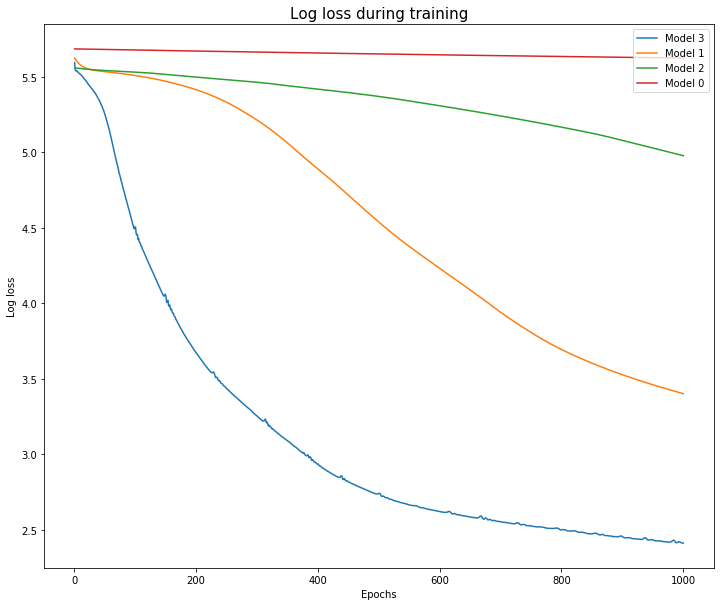

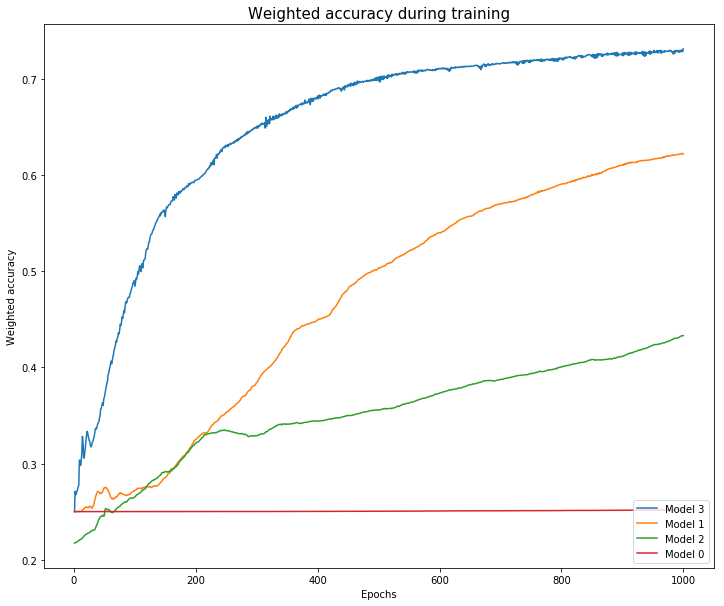

In [16]:
# Results - Fully Connected NN
ind = np.argsort(-1 * np.array(recall_deep_net[1]))
best_neural_net = deep_networks[ind[0]]
y_pred = np.argmax(best_neural_net.model.predict(test_set[features]), axis=1)

models_to_plot = min([MODELS_TO_PLOT, len(deep_networks)])
plot_training_progress(deep_networks, ind[:models_to_plot], "loss")
plot_training_progress(deep_networks, ind[:models_to_plot], "weighted_acc")

In [17]:
best_neural_net.model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 10)                240       
_________________________________________________________________
activation_9 (Activation)    (None, 10)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 39)                429       
_________________________________________________________________
activation_10 (Activation)   (None, 39)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 160       
_________________________________________________________________
activation_11 (Activation)   (None, 4)                 0         
Total params: 829
Trainable params: 829
Non-trainable params: 0
________________________________________________________

In [18]:
res = import_perceptron_stats("deep_net_stats.json")
print("Best learning rate: {}".format(res["learning_rate"][ind[0]]))
print("Best learning rate decay: {}".format(res["lr_decay"][ind[0]]))
print("Best neurons count: {}".format(res["deep_layers"][ind[0]]))


Best learning rate: 0.007809881411727638
Best learning rate decay: 3.398004852138903e-08
Best neurons count: 39


Normalized confusion matrix
[[0.26866438 0.24554795 0.06369863 0.42208904]
 [0.09647495 0.85528757 0.03896104 0.00927644]
 [0.02267373 0.02473498 0.9356596  0.01693168]
 [0.11223458 0.00101112 0.02932255 0.85743175]]


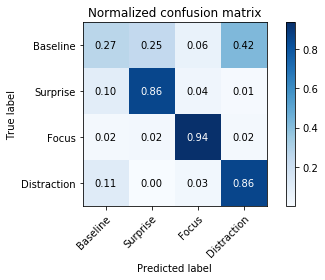

In [19]:
plot_confusion_matrix(y_true, y_pred, CLASS2LABEL, normalize=True, title="Normalized confusion matrix")

In [24]:
filepath = "deep_net_model_{}.h5".format(ind[0])
new_model = tf.keras.models.load_model(filepath)

features = list(train_set)
features.remove(LABEL)
x_train = train_set[features]
y_train = tf.keras.utils.to_categorical(train_set[LABEL])

In [38]:
#new_model = tf.keras.models.load_model("best_deep_net_ever.h5")
new_model.fit(x_train, y_train, class_weight=class_weights, epochs=int(1e5), batch_size=BATCH_SIZE, verbose=0)
new_model.save("best_deep_net_ever.h5")

Normalized confusion matrix
[[0.40924658 0.16327055 0.03553082 0.39195205]
 [0.08163265 0.8961039  0.01855288 0.00371058]
 [0.02473498 0.01619552 0.94213781 0.01693168]
 [0.1223458  0.00404449 0.01921132 0.85439838]]


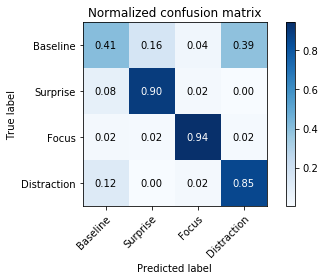

In [39]:
y_pred = np.argmax(new_model.predict(test_set[features]), axis=1)
plot_confusion_matrix(y_true, y_pred, CLASS2LABEL, normalize=True, title="Normalized confusion matrix")

In [35]:
# Fit LightGBM
lgb_models, recall_lgb, _ = train_lgb_model(train_set, test_set, LABEL, 1/3600)

Normalized confusion matrix
[[0.51678082 0.11669521 0.02611301 0.34041096]
 [0.04638219 0.9406308  0.01298701 0.        ]
 [0.0151649  0.00809776 0.9696702  0.00706714]
 [0.0677452  0.00101112 0.00303337 0.92821031]]


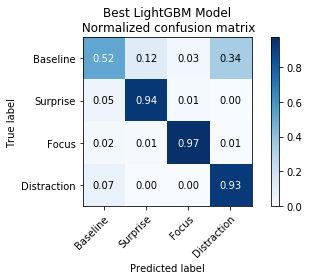

In [36]:
ind = np.argsort(-1 * np.array(recall_lgb[1]))
best_lbg = lgb_models[ind[0]]
y_pred = np.argmax(best_lbg.predict(test_set[features], num_iteration=best_lbg.best_iteration), axis=1)
plot_confusion_matrix(y_true, y_pred, CLASS2LABEL, normalize=True, title="Best LightGBM Model\n Normalized confusion matrix")

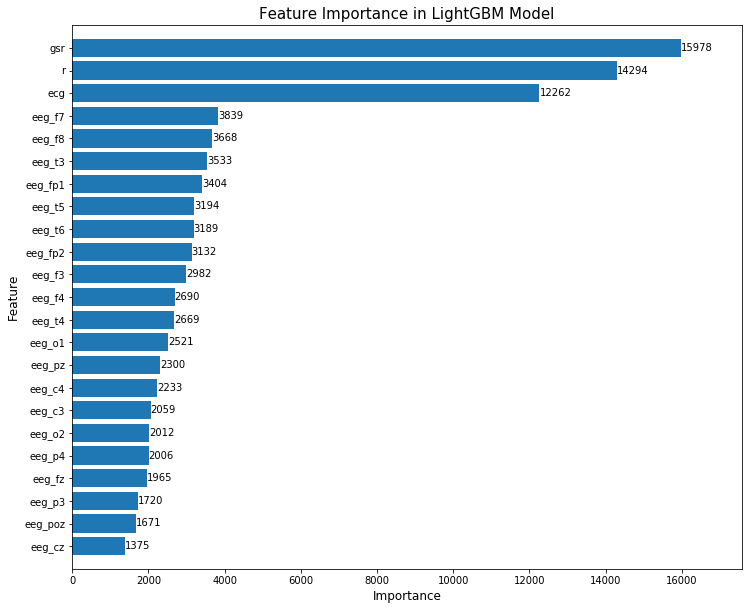

In [37]:
plot_feature_importance(best_lbg, True)